# Running SEIR++ simulations

import required modules and classes

In [1]:
import numpy as np
import pandas as pd
from pydemic.models import SEIRPlusPlusSimulation
from pydemic import MitigationModel
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 16

Specify a state. The current case data, total population, and age distribution models are then obtained.

In [2]:
state = "Illinois"
from pydemic.data.united_states import nyt, get_population, get_age_distribution
data = nyt(state)
total_population = get_population(state)
age_distribution = get_age_distribution()

Choose simulation time range.
The initial time is specified as a non-integer number of days from 2020/1/1
(as obtained from fitting), but the final day can be expressed as a date
tuple (which is suitably converted by the `days_from` function).

In [3]:
tspan = ('2020-02-15', '2020-06-01')

Specify model parameters.

In [4]:
from pydemic.distributions import GammaDistribution

parameters = dict(
    ifr=.003,
    r0=2.3,
    serial_dist=GammaDistribution(mean=4, std=3.25),
    seasonal_forcing_amp=.1,
    peak_day=15,
    incubation_dist=GammaDistribution(5.5, 2),
    p_symptomatic=np.array([0.057, 0.054, 0.294, 0.668, 0.614, 0.83 , 0.99 , 0.995, 0.999]),
#     p_positive=1.5,
    hospitalized_dist=GammaDistribution(6.5, 1.6),
    p_hospitalized=np.array([0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]),
    discharged_dist=GammaDistribution(9, 6),
    critical_dist=GammaDistribution(3, 1),
    p_critical=.9 * np.array([0.05 , 0.05 , 0.05 , 0.05 , 0.063, 0.122, 0.274, 0.432, 0.709]),
    dead_dist=GammaDistribution(7.5, 5.),
    p_dead=1.2 * np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]),
    recovered_dist=GammaDistribution(9, 2.2),
    all_dead_dist=GammaDistribution(3, 3),
    all_dead_multiplier=1.,
)

Specify a mitigation model via a list of time (in days from 2020/1/1) and factors on those days.

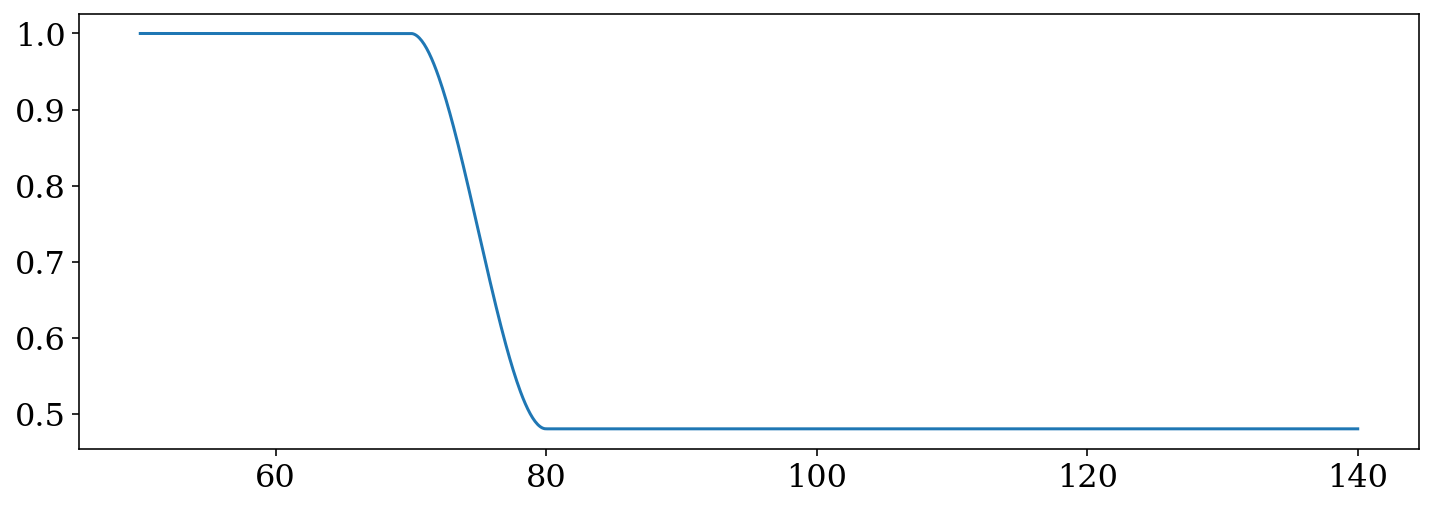

In [5]:
t0, tf = 50, 140
times = [70, 80]
factors = [1, .48] 
mitigation = MitigationModel(t0, tf, times, factors)
fig, ax = plt.subplots(figsize=(12, 4))
_t = np.linspace(t0, tf, 1000)
ax.plot(_t, mitigation(_t))

Initialize and run the simulation.

In [6]:
sim = SEIRPlusPlusSimulation(total_population, age_distribution,
                             mitigation=mitigation, **parameters)

initial_cases = 10
y0 = {}
y0['infected'] = initial_cases * np.array(age_distribution)
y0['susceptible'] = (
    total_population * np.array(age_distribution) - y0['infected']
)


result = sim(tspan, y0, .05)
_t = result.t
result.t = pd.to_datetime(result.t, unit='D', origin='2020-01-01')

Plot the results.

In [7]:
plot_compartments = [
    'infected',
    'positive',
    'all_dead',
    'hospitalized',
]

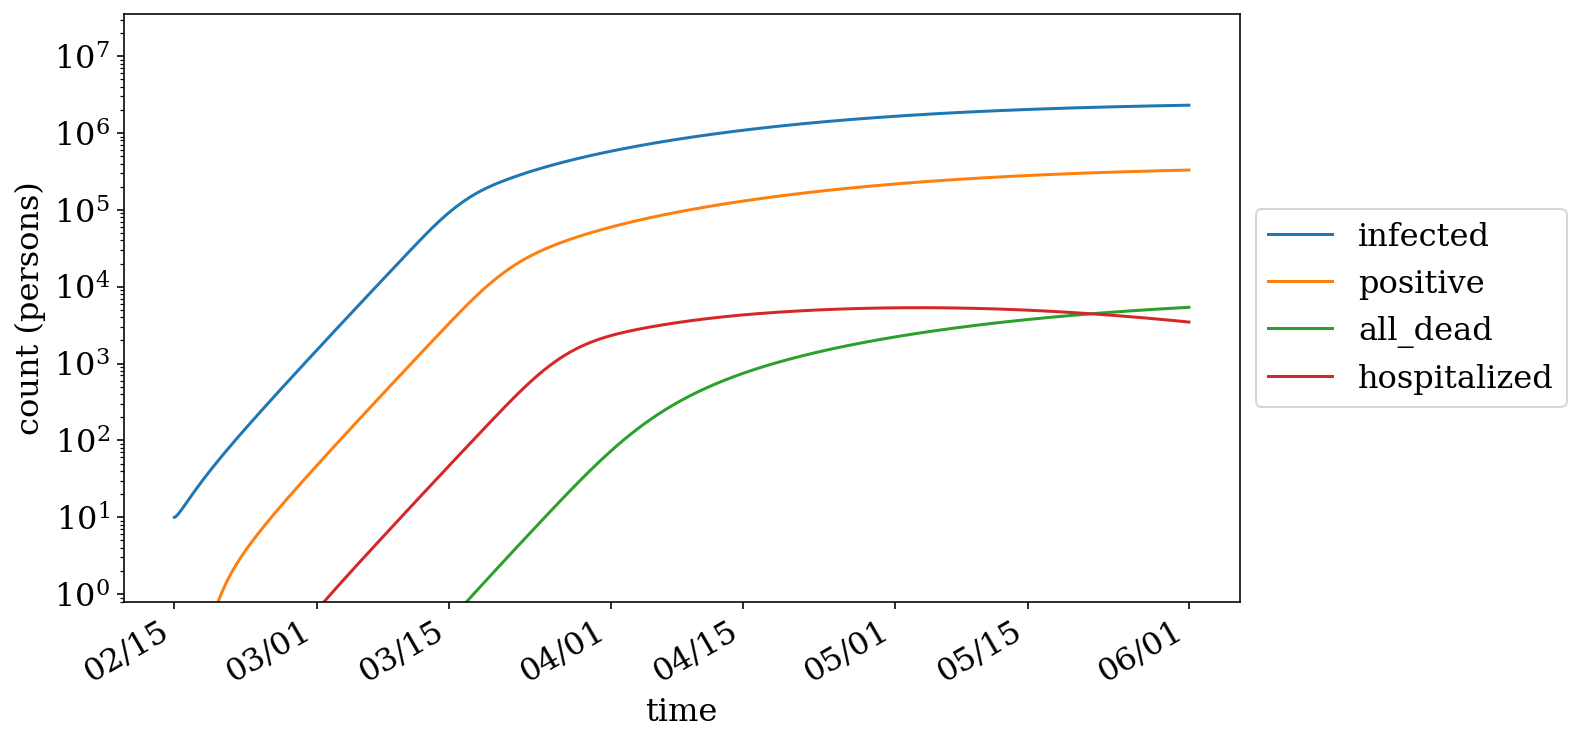

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

for name in plot_compartments:
    ax.plot(result.t,
            (result.y[name].sum(axis=1)),
            label=name)

ax.plot()
# plot on y log scale
ax.set_yscale('log')
ax.set_ylim(ymin=0.8)

# plot x axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
fig.autofmt_xdate()

# create legend
ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.set_xlabel('time')
ax.set_ylabel('count (persons)');

Plot the death counts against the simulation result.
The containment model is plotted on the bottom panel.

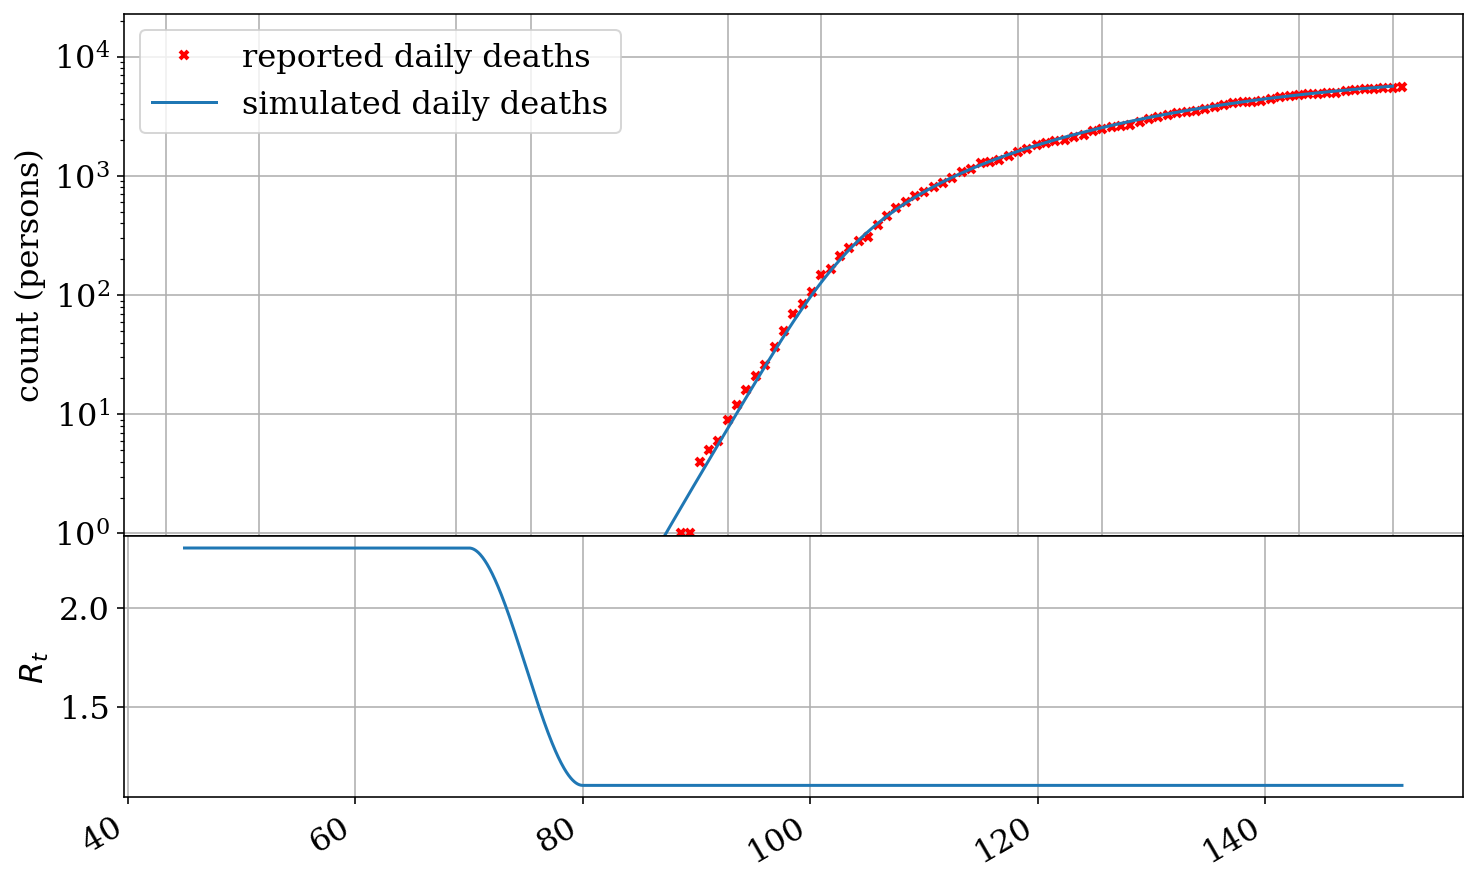

In [9]:
fig = plt.figure(figsize=(12, 8))

import matplotlib.gridspec as gridspec
gspec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax = [fig.add_subplot(gspec[:2,0]), fig.add_subplot(gspec[2,0])]

ax[0].semilogy(data.index, data.all_dead,
            'x', c='r', ms=4, markeredgewidth=2,
            label='reported daily deaths')

ax[0].semilogy(result.t, result.y['dead'].sum(axis=1),
            '-', linewidth=1.5, label='simulated daily deaths')

ax[1].plot(_t, parameters['r0'] * mitigation(_t),
            '-', linewidth=1.5)

ax[0].set_ylabel("count (persons)")
ax[1].set_ylabel(r'$R_t$')
ax[0].set_ylim(.95, .5 * ax[0].get_ylim()[1])
ax[0].legend()

fig.autofmt_xdate()
ax[0].grid()
ax[1].grid()
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig('seirpp_best_fit.png')